# sidebands

Python notebook to calculate the spectral sidebands in the optical output of a sinusoidally driven electro-optic phase modulator or Mach Zehnder interferometer.

In [324]:
from scipy.special import jv,jn_zeros,jnp_zeros,jnjnp_zeros
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi,sin,cos,exp,abs

## Phase modulator

### Background

The electric field of a phase modulator when driven with sinusoidal voltage is

$$ E = E_0 \exp(i \omega_0 t) \exp(i \beta \sin \omega t) $$

where $\omega_0 = 2 \pi c / \lambda$ is the optical frequency, $\omega = 2 \pi f$ is the drive frequency, and $\beta = \pi V / V_{\pi}$ is the drive amplitude. Expanded in Bessel functions, we have

$$ E = E_0 \exp(i \omega_0 t) \sum_{n=-\infty}^{\infty} J_n(\beta) \exp(i n \omega t) $$

Defining $\omega_n \equiv \omega_0 + n \omega$,

$$ E = E_0 \sum_{n=-\infty}^{\infty} \exp(i \omega_n t) J_n(\beta) $$

The Bessel functions for negative $n$ satisfy $ J_{-n}(\beta) = (-1)^n J_n(\beta) $. Assuming intensity is equal to the field squared, the relative intensity $I_n$ of the sideband at $\omega_n$ is

$$ I_n = |E_0|^2 J_n^2(\beta) $$

which satisfies $\sum_{-\infty}^{\infty} I_n = |E_0|^2$.

### Functions

In [325]:
def pmamplitude(n,beta): # sideband ampltude given n = sideband number, beta = pi*V/Vpi
    return jv(n,beta)
def pmintensity(n,beta): # sideband intensity given n = sideband number, beta = pi*V/Vpi
    return pmamplitude(n,beta)**2

We observe the calculated sideband intensities sum to one:

In [326]:
beta,N = 1.5,10
sum(pmintensity(n,beta) for n in range(-N,N+1))

0.9999999999999997

In [327]:
pmintensity(0,0)

1.0

### Sideband plots

A plot of $I_n$ as a function of drive voltage for the first few sidebands, assuming $V_\pi$ = 1 V:

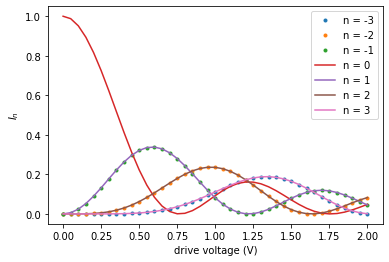

In [328]:
def pmsidebandplot(vpi,N=3):
    wx = np.linspace(0,2*vpi,41)
    for n in range(-N,N+1):
        plt.plot(wx, pmintensity(n,pi*wx/vpi), '.' if n<0 else '-', label=f'n = {n}')
    plt.legend(); plt.xlabel('drive voltage (V)'); plt.ylabel('$I_n$')
pmsidebandplot(vpi=1)

### $V_\pi$ from sideband intensity

Typically we will measure the phase modulator response at a particular frequency by applying an AC waveform to the electrode and noting the voltage amplitude that it takes for the first sidebands to be exactly 20% relative to the fundamental. As calculated below, at a 20% sideband ratio the drive voltage is 0.26 times $V_\pi$:
$$ V_\pi = \frac{V_{peak}}{0.260183} = \frac{V_{pp}}{0.520366} $$

V/Vpi at  5%: 0.138868
V/Vpi at 10%: 0.191992
V/Vpi at 20%: 0.260183
V/Vpi at 30%: 0.30654


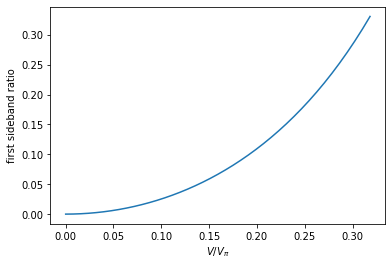

In [329]:
betas = np.linspace(0,1,41)
sbs = pmintensity(1,betas)/pmintensity(0,betas)
print(f'V/Vpi at  5%: {np.interp(0.05,sbs,betas)/pi:g}')
print(f'V/Vpi at 10%: {np.interp( 0.1,sbs,betas)/pi:g}')
print(f'V/Vpi at 20%: {np.interp( 0.2,sbs,betas)/pi:g}')
print(f'V/Vpi at 30%: {np.interp( 0.3,sbs,betas)/pi:g}')
plt.plot(betas/pi, sbs); plt.xlabel(r'$V/V_\pi$'); plt.ylabel('first sideband ratio');

## Mach Zehnder modulator

### Background

The electric field at the output of a push-pull Mach Zehnder modulator is proportional to the sum of the fields in each leg

$$ E = E_A \exp[i \omega_0 t + i \phi_A + i \beta_A \sin \omega t] + E_B \exp[i \omega_0 t + i \phi_B + i \beta_B \sin \omega t] $$

after Bessel expansion we have

$$ E = \exp[i\omega_0 t] \sum_{n=-\infty}^{\infty} \exp[in\omega t] \left( E_A \exp[i \phi_A] J_n(\beta_A) + E_B \exp[i \phi_B] J_n(\beta_B) \right) $$

Defining $\omega_n \equiv \omega_0 + n \omega$,

$$ E = \sum_{n=-\infty}^{\infty} \exp[i\omega_nt] \left( E_A \exp[i \phi_A] J_n(\beta_A) + E_B \exp[i \phi_B] J_n(\beta_B) \right) $$

The relative intensity $I_n$ of the sideband at $\omega_n$ is

$$ I_n = \lvert E_A \exp[i \phi_A] J_n(\beta_A) + E_B \exp[i \phi_B] J_n(\beta_B) \rvert ^2 $$

$$ = E_A^2 J_n^2(\beta_A) + E_B^2 J_n^2(\beta_B) + 2 E_A E_B J_n(\beta_A) J_n(\beta_B) \cos \phi $$

where $ \phi =  \phi_B - \phi_A$

### Functions

In [330]:
def mzamplitude(n,E0,E1,phi,beta0,beta1): # Mach Zehnder sideband ampltude
    return E0*jv(n,beta0) + E1*jv(n,beta1)*exp(1j*phi)
def mzintensity(n,E0,E1,phi,beta0,beta1): # Mach Zehnder sideband intensity
    return E0**2*jv(n,beta0)**2 + E1**2*jv(n,beta1)**2 + \
        E0*E1*jv(n,beta0)*jv(n,beta1)*cos(phi)

### Temporal plots

The expected time dependent output of a balanced Mach Zehnder is

$$ I(t) = E_A^2 + E_B^2 + 2 E_A E_B \cos( \phi + \Delta \beta \sin \omega t ) $$

where $\Delta \beta = \beta_B - \beta_A$.

In the following plot we find that this matches the time dependent output that we get from the infinite sum:

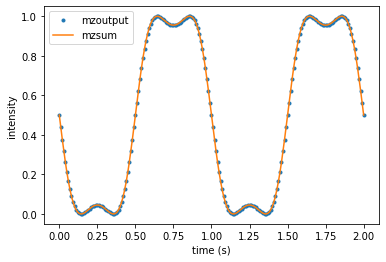

In [331]:
def mzoutput(E0,E1,phi,db,f,t):
    return E0**2 + E1**2 + 2*E0*E1*cos(phi+db*sin(2*pi*f*t))
def mzsum(E0,E1,phi,beta0,beta1,f,t,N=10):
    return abs(sum( exp(1j*2*pi*n*f*t) * mzamplitude(n,E0,E1,phi,beta0,beta1) for n in range(-N,N+1) ))**2
def timeplot(E0,E1,phi,beta0,beta1,f=1,N=None):
    wx = np.linspace(0,2/f,201)
    if N is None:
        wy = mzoutput(E0,E1,phi,beta1-beta0,f,wx)
        plt.plot(wx, wy, '.', label='mzoutput')
    else:
        wy = mzsum(E0,E1,phi,beta0,beta1,f,wx,N=N)
        plt.plot(wx, wy, '-', label='mzsum')
    plt.legend(); plt.xlabel('time (s)'); plt.ylabel('intensity')
timeplot(0.5, 0.5, pi/2, -1, +1)
timeplot(0.5, 0.5, pi/2, -1, +1, N=10)

We find that, even if unbalanced, the time dependent output depends only on $\Delta \beta = \beta_B - \beta_A$ and not the individual values of $\beta_A$ and $\beta_B$:

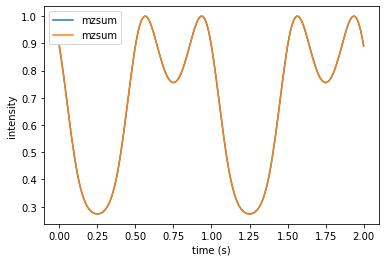

In [332]:
timeplot(0.25, 0.75, pi/4, beta0=-2, beta1=+0, N=10)
timeplot(0.25, 0.75, pi/4, beta0=-1, beta1=+1, N=10)

Interestingly, however, the sideband intensities depend individually on $\beta_A$ and $\beta_B$, not just their difference. We can see there is a difference by plotting a partial sum of the Bessel terms:

n -1 In 0.020788218992637678 0.06968006682367776
n 0 In 0.6250009506274947 0.5212161117500331
n 1 In 0.020788218992637678 0.06968006682367776


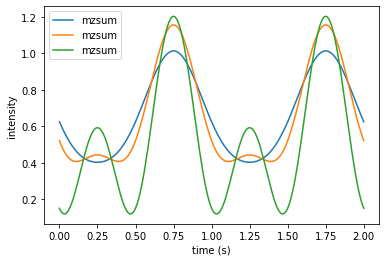

In [333]:
timeplot(0.25, 0.75, pi/4, beta0=-2, beta1=+0, N=1)
timeplot(0.25, 0.75, pi/4, beta0=-1, beta1=+1, N=1)
timeplot(0.25, 0.75, pi/4, beta0=-0, beta1=+2, N=1)
for n in (-1,0,+1):
    print('n',n,'In',abs(mzamplitude(n,0.25,0.75,pi/4,-2,0))**2,abs(mzamplitude(n,0.25,0.75,pi/4,-1,+1))**2)

### Sideband plots

We see that the plot of sideband intensity as a function of drive voltage is the same as for the phase modulator, as long as the drive response is balanced (i.e. $\beta_B = -\beta_A$) and the DC phase is at quadrature. The $V_\pi$ of the phase modulator in each leg is chosen to be 1 V. The $V_\pi$ of the push-pull Mach Zehnder modulator itself is 0.5 V.

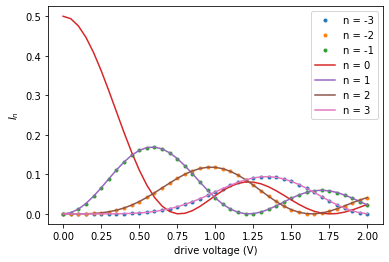

In [334]:
def mzsidebandplot(E0,E1,phi,vpi0=1,vpi1=1,N=3):
    wx = np.linspace(0,2*vpi0,41)
    for n in range(-N,N+1):
        wy = mzintensity(n,E0,E1,phi,beta0=-pi*wx/vpi0,beta1=+pi*wx/vpi1)
        plt.plot(wx, wy, '.' if n<0 else '-', label=f'n = {n}')
    plt.legend(); plt.xlabel('drive voltage (V)'); plt.ylabel('$I_n$')
mzsidebandplot(0.5, 0.5, pi/2)

The relative sideband strengths are also the same even if the fields in each arm are unbalanced:

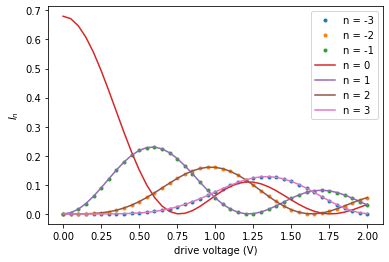

In [335]:
mzsidebandplot(0.2, 0.8, pi/2)

Something different emerges, however, if the Mach Zehnder is not at quadrature:

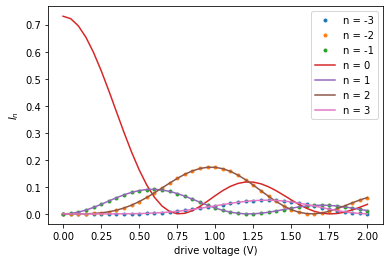

In [336]:
mzsidebandplot(0.5, 0.5, pi/8)

Note that it is always the case that the strength of the negative sideband is equal to its positive counterpart.

### Vπ for a Mach Zehnder modulator

For a single-sided Mach Zehnder modulator (consisting of a phase modulator in one leg and a passive waveguide in the other), the $V_\pi$ of the Mach Zehnder is the same as the phase modulation $V_\pi$. A push-pull Mach Zehnder modulator (consisting of phase modulators in both legs) has a $V_\pi$ equal to half that of the phase modulation $V_\pi$ of one of its phase modulators.

Here is a plot of sideband intensity in terms of drive voltage ($V_{peak} = 
V_{pp}/2$) for a balanced Mach Zehnder at quadrature.

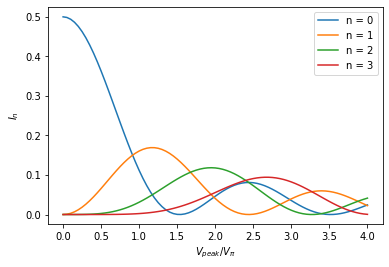

In [337]:
def mzplot(E0,E1,phi,N=3):
    wx = np.linspace(0,4,81)
    for n in range(0,N+1):
        wy = mzintensity(n,E0,E1,phi,beta0=-pi/2*wx,beta1=+pi/2*wx)
        plt.plot(wx, wy, label=f'n = {n}')
    plt.legend(); plt.xlabel('$V_{peak} / V_\pi$'); plt.ylabel('$I_n$')
mzplot(0.5, 0.5, pi/2)

The intensity of the nth sideband is proportional to $J_n^2$ regardless of the DC bias, so the drive voltage at which a side band is maximum or minimum (i.e. zero) can be used to effectively determine the $V_\pi$ of the Mach Zehnder modulator.

For example, $J_1$ has a peak corresponding to $J_1'(1.8412)=0$, so if $V_{peak}$ is the voltage at which this occurs, then:
$$ V_\pi = \frac{\pi}{2}\frac{V_{peak}}{1.8412} $$

In [338]:
print(jn_zeros(0,6),"J0 zeros")
print(jnp_zeros(1,6),"J1' zeros")
print(jnjnp_zeros(6)[0],"Zeros of any Jn or Jn'")

[ 2.40482556  5.52007811  8.65372791 11.79153444 14.93091771 18.07106397] J0 zeros
[ 1.84118378  5.33144277  8.53631637 11.7060049  14.86358863 18.01552786] J1' zeros
[0.         1.84118378 2.40482556 3.05423693 3.83170597 3.83170597] Zeros of any Jn or Jn'


## Pockels cell modulator

A Pockels cell modulator is similar to a Mach Zehnder modulator, with the horizontal (H) and vertical (V) polarized fields corresponding to the fields in each of the two legs. It consists of an input linear polarizer, acting as a beam splitter, and its angle controls the relative field in each of the H and V legs. The Pockels cell itself produces a phase delay, different for H and V, that is proportional to the voltage applied. Another linear polarizer at the output acts as a recombining beam splitter.

### Fields at DC

If we assume a horizontally polarized input laser, the fields after the input polarizer oriented at angle $\theta$ (from horizontal) are

$$ E_H = E_0 \cos^2 \theta $$
$$ E_V = E_0 \cos \theta \sin \theta $$

At the exit of the crystal the fields are

$$ E_H = E_0 \cos^2 \theta \exp[i \pi V / V_H]$$
$$ E_V = E_0 \cos \theta \sin \theta \exp[i \pi V / V_V]$$

Where $V$ is the applied voltage and $V_H$ and $V_V$ are defined as $V_\pi$ for each polarization. Finally the combined field after the output polarizer oriented at angle $\phi$ (from horizontal) is

$$ E_H = E_0 \cos^2 \theta \exp[i \pi V / V_H] \cos \phi$$
$$ E_V = E_0 \cos \theta \sin \theta \exp[i \pi V / V_V] \sin \phi$$
$$ E = E_H + E_V = E_0 \cos \theta (\cos \theta \cos \phi \exp[i \pi V / V_H] + \sin \theta \sin \phi \exp[i \pi V / V_V])$$

Maximum interference occurs when the input polarizer is set to $\theta = \pi/4$

$$ E = \tfrac{1}{2} E_0 (\cos \phi \exp[i \pi V / V_H] + \sin \phi \exp[i \pi V / V_V])$$

In [339]:
# Notes for determining correct polarization state using Jones matrices
θ = pi/4 # input polarizer angle
φ = pi/4 # output polarizer angle
E0 = np.array([[1.],
               [0.]])
P0 = np.array([[cos(θ)*cos(θ), cos(θ)*sin(θ)],
               [cos(θ)*sin(θ), sin(θ)*sin(θ)]])
PH = np.array([[ 1, 0 ],
               [ 0, 0 ]])
HWP = np.array([[ cos(φ/2)**2-sin(φ/2)**2,     2*sin(φ/2)*cos(φ/2) ],
                [     2*sin(φ/2)*cos(φ/2), sin(φ/2)**2-cos(φ/2)**2 ]])
PHHWP = np.array([[ cos(φ/2)**2-sin(φ/2)**2,     2*sin(φ/2)*cos(φ/2) ],
                  [                       0,                       0 ]])
PHHWP = np.array([[ cos(φ), sin(φ) ],
                  [      0,      0 ]])
def pe(v,norm=True): # returns xs,ys for parametric plot of polarization ellipse
    θs = np.linspace(0,2*pi,41)
    u0 = np.sqrt(sum(abs(v)**2)) if norm else 1
    return np.real(v[0][0]*exp(1j*θs))/u0, np.real(v[1][0]*exp(1j*θs))/u0
# plt.plot(*pe(E0),label='E0'); plt.plot(*pe(P0 @ E0),label='P0 @ E0'); plt.plot(*pe(HWP @ P0 @ E0),'.',label='HWP @ P0 @ E0'); plt.legend(); plt.xlabel('Ex'); plt.ylabel('Ey'); plt.gca().set_aspect('equal'); plt.xlim(-1.2,1.2); plt.ylim(-1.2,1.2); plt.show()
P0  # input polarizer
P1 = PH @ HWP # output polarizer
PH @ HWP @ P0 @ E0, PHHWP @ P0 @ E0; # output field

### Time dependent fields

Including time dependence now, the derivation is the same as for the Mach Zehnder above.

$$ E(t) = E_H \exp[i \omega_0 t + i \phi_H + i \beta_H \sin \omega t] + E_V \exp[i \omega_0 t + i \phi_V + i \beta_V \sin \omega t] $$

with

$$ E_H = (E_0 \cos \theta) \cos \theta \cos \phi$$

$$ E_V = (E_0 \cos \theta) \sin \theta \sin \phi$$

Where we have defined the following

$$\beta_H ≡ \pi V / V_H$$
$$\beta_V ≡ \pi V / V_V$$
$$\phi_H ≡ \pi V_{DC} / V_H$$
$$\phi_V ≡ \pi V_{DC} / V_V$$
where $V$ is the sinusoidal voltage and $V_{DC}$ is the DC offset. Then

$$ E(t) = \sum_{n=-\infty}^{\infty} \exp[i\omega_nt] \left( E_H e^{i \phi_H} J_n(\beta_H) + E_V e^{i \phi_V} J_n(\beta_V) \right) $$

The relative intensity $I_n$ of the sideband at $\omega_n$ is

$$ I_n = \lvert E_H e^{i \phi_H} J_n(\beta_H) + E_V e^{i \phi_V} J_n(\beta_V) \rvert ^2 $$

$$ I_n = E_H^2 J_n^2(\beta_H) + E_V^2 J_n^2(\beta_V) + 2 E_H E_V J_n(\beta_H) J_n(\beta_V) \cos (\phi_V - \phi_H) $$

$$ I_n = E_0^2 \cos^2 \theta \left[ J_n^2(\beta_H) \cos^2 \theta \cos^2 \phi + J_n^2(\beta_V) \sin^2 \theta \sin^2 \phi + 2 J_n(\beta_H) J_n(\beta_V) \cos \theta \cos \phi \sin \theta \sin \phi \cos (\phi_V - \phi_H) \right]$$

An alternative form can be found using double angle identities

<!---
$$\sin^2\theta = \frac{1-\cos(2\theta)}{2}$$
$$\cos^2\theta = \frac{1+\cos(2\theta)}{2}$$
$$\sin^2\phi = \frac{1-\cos(2\phi)}{2}$$
$$\cos^2\phi = \frac{1+\cos(2\phi)}{2}$$
$$\sin\theta\cos\theta = \frac{\sin(2\theta)}{2}$$
$$\sin\phi\cos\phi = \frac{\sin(2\phi)}{2}$$
$$ I_n = E_0^2 \left( \frac{1-\cos(2\theta)}{2} \right)  \left( \frac{1-\cos(2\phi)}{2} \right)  \left[ J_n^2(\beta_H) \left( \frac{1+\cos(2\theta)}{2} \right)  \left( \frac{1+\cos(2\phi)}{2} \right)  + J_n^2(\beta_V) \left( \frac{1-\cos(2\theta)}{2} \right)  \left( \frac{1-\cos(2\phi)}{2} \right)  + 2 J_n(\beta_H) J_n(\beta_V) \left( \frac{\sin(2\theta)}{2}  \right) \left( \frac{\sin(2\phi)}{2}  \right) \cos (\phi_V - \phi_H) \right]$$
--->

$$ I_n = \tfrac{1}{16} E_0^2 \left( {1-\cos 2\theta} \right)  \left[ J_n^2(\beta_H) \left( {1+\cos 2\theta} \right)  \left( {1+\cos 2\phi} \right)  + J_n^2(\beta_V) \left( {1-\cos 2\theta} \right)  \left( {1-\cos 2\phi} \right)  + 2 J_n(\beta_H) J_n(\beta_V) \sin 2\theta \sin 2\phi \cos (\phi_V - \phi_H) \right]$$

### Balanced input

For the case of balanced input fields, $\theta = \pi/4$, this simplifies to

$$ I_n = \tfrac{1}{4} E_0^2 \left[ J_n^2(\beta_H) \cos^2 \phi + J_n^2(\beta_V) \sin^2 \phi + 2 J_n(\beta_H) J_n(\beta_V) \cos \phi \sin \phi \cos (\phi_V - \phi_H) \right]$$

Setting $\phi_V - \phi_H = 0,\pi/4,\pi/2$ at the output corresponds to full-bias, quadrature, and null-bias:

- At full-bias: $ I_n = \tfrac{1}{4} E_0^2 \left[ J_n^2(\beta_H) \cos^2 \phi + J_n^2(\beta_V) \sin^2 \phi + 2 J_n(\beta_H) J_n(\beta_V) \cos \phi \sin \phi \right]$

- At quadrature: $I_n = \tfrac{1}{4} E_0^2 \left[ J_n^2(\beta_H) \cos^2 \phi + J_n^2(\beta_V) \sin^2 \phi + \sqrt{2} J_n(\beta_H) J_n(\beta_V) \cos \phi \sin \phi \right]$

- At null-bias: $ I_n = \tfrac{1}{4} E_0^2 \left[ J_n^2(\beta_H) \cos^2 \phi + J_n^2(\beta_V) \sin^2 \phi \right]$

### Balanced input and output

For the case of balanced interference at both input and output ($\theta = \pi/4$, $\phi = \pi/4$)

$$ I_n = \tfrac{1}{16} E_0^2 \left[ J_n^2(\beta_H) + J_n^2(\beta_V) + 2 J_n(\beta_H) J_n(\beta_V) \cos (\phi_V - \phi_H) \right]$$

Setting $\phi_V - \phi_H = 0,\pi/4,\pi/2$ at the output corresponds to full-bias, quadrature, and null-bias:

- At full-bias: $ I_n = \tfrac{1}{16} E_0^2 \left[ J_n^2(\beta_H) + J_n^2(\beta_V) + 2 J_n(\beta_H) J_n(\beta_V) \right] = \tfrac{1}{16} E_0^2 \left[ J_n(\beta_H) + J_n(\beta_V) \right]^2$

- At quadrature: $I_n = \tfrac{1}{16} E_0^2 \left[ J_n^2(\beta_H) + J_n^2(\beta_V) + \sqrt{2} J_n(\beta_H) J_n(\beta_V) \right]$

- At null-bias: $ I_n = \tfrac{1}{16} E_0^2 \left[ J_n^2(\beta_H) + J_n^2(\beta_V) \right]$

## Appendix

### Bessel function identities

$$ e^{i x \sin θ} = \sum_{n=-\infty}^{\infty} J_n(x) e^{i n θ} $$

$$ e^{i x \cos θ} = \sum_{n=-\infty}^{\infty} i^n J_n(x) e^{i n θ} $$

$$ J_{-n}(x) = (-1)^n J_n(x) = J_n(-x) $$

$$ \int_{0}^{\infty} J_n(x) dx = 1 $$

$$ \sum_{n=-\infty}^{\infty} J_n(x) = 1 $$

$$ \sum_{n=-\infty}^{\infty} J_n^2(x) = 1 $$

$$ \sum_{n=-\infty}^{\infty} n J_n(x) = x $$

$$ \sum_{n=-\infty}^{\infty} J_n(x) J_{n-k}(x) = \delta_{k,0} $$

$$ J_k(x+y) = \sum_{n=-\infty}^{\infty} J_n(x) J_{k-n}(y) $$

$$ J_k(x-y) = \sum_{n=-\infty}^{\infty} J_n(x) J_{n-k}(y) $$

$$ \lim_{x \to 0} J_n(x) = \frac{1}{n!} \left(\frac{x}{2}\right)^n $$

$$ \lim_{x \to \infty} J_n(x) = \sqrt{ \frac{2}{\pi x} } \cos \left( x - \frac{2n+1}{4}\pi \right) $$

### Double angle identities

$$\sin^2\theta = \frac{1-\cos(2\theta)}{2}$$
$$\cos^2\theta = \frac{1+\cos(2\theta)}{2}$$
$$\sin\theta\cos\theta = \frac{\sin(2\theta)}{2}$$

In [340]:
# %history # show all code